In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM,GRU
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D,MaxPooling1D,GlobalAveragePooling1D,Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
df = pd.read_csv("../data/phase2_train.csv", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)

(3004066, 4)


,timestamp,value,label,KPI ID
0,1476460800,0.012604,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
1,1476460860,0.017786,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
2,1476460920,0.012014,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
3,1476460980,0.017062,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
4,1476461040,0.023632,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd


In [15]:
data= df[["value","label"]]
a=data[ 200000:300000]##点集epoch=22 
print(a['label'].value_counts())
normal=a[(a['label']== 0) ]#
normal=normal[~normal['value'].isin([0])]
normal=normal["value"]
validation=data[220000:250000]#
validation=validation[~validation['value'].isin([0])]
test=data[190000:220000]#
test=test[~test['value'].isin([0])]
for i in range(len(test)):
    if((test.iloc[i,0] < 200) and (test.iloc[i,1] == 1)):
        test.iloc[i,1]=0        
test_label=test['label']
test_label=test_label.tolist()
print("test",test['label'].value_counts())
print("validation",validation['label'].value_counts())
test_copy=test["value"]

0    99905
1       95
Name: label, dtype: int64
test 0    1400
1      10
Name: label, dtype: int64
validation 0    1246
1      10
Name: label, dtype: int64


In [16]:

test=np.array(test['value'])
validation=np.array(validation['value'])
train=np.array(normal)
timesquence=20
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
trim=len(validation)%timesquence
validation=validation[:len(validation)-trim]
validation.shape=(int(len(validation)/timesquence),timesquence,1)
print("validation",validation.shape)
print("train",train.shape)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

validation (62, 20, 1)
train (241, 20, 1)
test (70, 20, 1)


In [12]:
print(x_train)

[[[25.        ]]

 [[14.16666698]]

 [[15.5       ]]

 ...

 [[ 6.80000019]]

 [[ 6.        ]]

 [[12.39999962]]]


In [41]:
#LSTM

# metric = 'mean_absolute_error'
# model = Sequential()
# model.add(LSTM(units=32, activation='tanh', input_shape=(timesquence, 1), return_sequences=True))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
# print(model.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 32)            4352      
_________________________________________________________________
dense_8 (Dense)              (None, 50, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
metric = 'mean_absolute_error'
model = Sequential()
model.add(GRU(units=32, activation='relu', input_shape=(20, 1), return_sequences=True))
model.add(GRU(units=16,activation='relu', return_sequences=True))
model.add(GRU(units=8,activation='relu', return_sequences=True))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 20, 32)            3264      
_________________________________________________________________
gru_5 (GRU)                  (None, 20, 16)            2352      
_________________________________________________________________
gru_6 (GRU)                  (None, 20, 8)             600       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 8)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 20, 1)             9         
Total params: 6,225
Trainable params: 6,225
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
x = Conv1D(filters=n_filters,
               kernel_size=filter_width,
             padding='causal',
              activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

model = Model(history_seq, pred_seq_train)
model.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 32)          96        
_________________________________________________________________
dense_17 (Dense)             (None, None, 128)         4224      
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_18 (Dense)             (None, None, 1)           129       
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1)           0         
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________

In [18]:

history=model.fit(train, train,
                  batch_size=32,
                   epochs=50,
                    validation_data=(validation, validation))


Train on 241 samples, validate on 62 samples
Epoch 1/50
241/241 [==============================] - 17s 73ms/step - loss: 13.5598 - mean_absolute_error: 13.5598 - val_loss: 17.0162 - val_mean_absolute_error: 17.0162
Epoch 2/50
241/241 [==============================] - 2s 7ms/step - loss: 13.3832 - mean_absolute_error: 13.3832 - val_loss: 16.8336 - val_mean_absolute_error: 16.8336
Epoch 3/50
241/241 [==============================] - 2s 7ms/step - loss: 13.0110 - mean_absolute_error: 13.0110 - val_loss: 16.1131 - val_mean_absolute_error: 16.1131
Epoch 4/50
241/241 [==============================] - 2s 7ms/step - loss: 12.2756 - mean_absolute_error: 12.2756 - val_loss: 15.1807 - val_mean_absolute_error: 15.1807
Epoch 5/50
241/241 [==============================] - 2s 7ms/step - loss: 11.2925 - mean_absolute_error: 11.2925 - val_loss: 13.5389 - val_mean_absolute_error: 13.5389
Epoch 6/50
241/241 [==============================] - 2s 6ms/step - loss: 10.6206 - mean_absolute_error: 10.6206 

241/241 [==============================] - 2s 7ms/step - loss: 5.1852 - mean_absolute_error: 5.1852 - val_loss: 4.3360 - val_mean_absolute_error: 4.3360


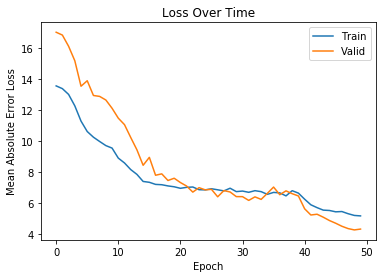

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [20]:
test_pred = model.predict(test)

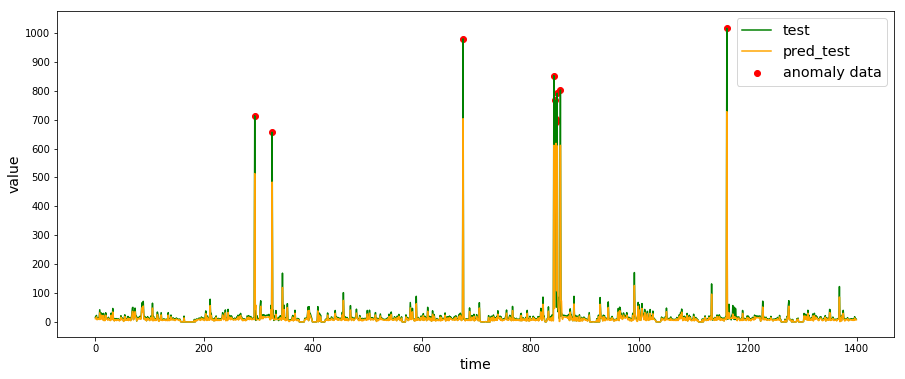

In [21]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')
for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [22]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[1.04713440e-03 3.24749947e-03 4.51040268e-03 ... 2.40593079e+02
 2.75832031e+02 2.87681091e+02]


In [23]:
PAscores[100]

0.23912906650918053

In [24]:
PAcutoff=int(0.95*len(PAscores))
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

12.43083190921211


In [25]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [26]:
normal_rela_erro=0.5
#集体集检测
timestep=5
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[ 0.          0.20984727  0.33556414  0.54566288  0.61845744  0.62314159
  0.63719767  0.99125627  1.03590727  1.0399341   1.13485432  1.1468935
  1.15489733  1.19778913  1.37360877  1.6385985   1.82648569  2.20457304
  2.5         3.44219273  3.5488286   3.65048969  4.10658944  4.45850718
  4.48362851  4.49398381  5.12189364  5.52266407  5.53320408  5.84690154
  6.04421306  6.80475807  7.38551253  7.63903487  7.6778717   8.12825155
  8.14836884  8.26312852  8.38605624  8.39002991  8.50156856  8.65680647
  8.67779708  8.68313819  8.78397989  8.94555426  9.07437181  9.26147366
  9.31413031  9.42041111  9.49359506  9.54112625  9.54925394  9.82974529
  9.83634877 10.48955059 10.54749727 10.55568695 10.58546072 10.66372728
 10.67862368 10.73397207 10.74677968 10.87453938 10.88886046 10.94535875
 11.02387953 11.03332186 11.0867939  11.1203022  11.18930817 11.196311
 11.21757746 11.25917768 11.32702017 11.44353962 11.47956228 11.52114964
 11.58182698 11.61133379 11.63230848 11.72055626 11.72

In [27]:
CAcutoff=int(0.99*len(CAscores))
CAthreshold=500#CAscores[CAcutoff]
print(CAscores[CAcutoff])

32.7384891510334


In [28]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [29]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

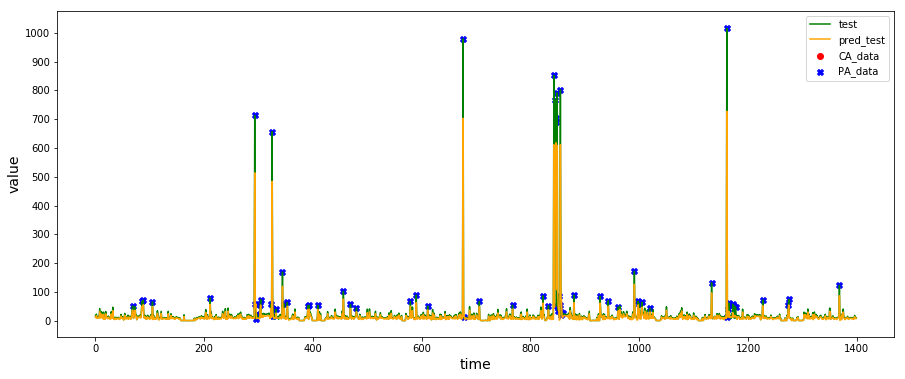

In [30]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [31]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [32]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 0
PA: 69
ROC_AUC score:97.877698%
PR-AUC score:57.246377%


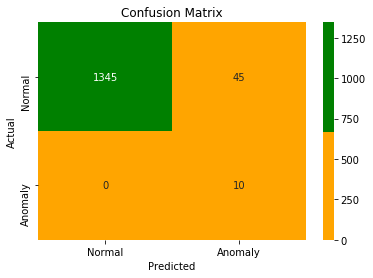

In [75]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)